# Implementation of the squeezed laser

In [286]:
import math as math
import numpy as np
import scipy as scipy
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.animation as animation
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import sys
import os

from qutip import *
from src_2_0 import *

In [287]:
def H_def(a,sigma,Delta_c,Delta_0,g,r,theta,omega=0,phi=0): # Defines the Hamiltonian of the system. It considers a coupling between a photonic cavity and a one-atom subsystem.
    return Delta_c*a.dag()*a+Delta_0*sigma.dag()*sigma+g*(sigma*(np.cosh(r)*a.dag()+np.exp(1j*theta)*np.sinh(r)*a)+sigma.dag()*(np.cosh(r)*a+np.exp(-1j*theta)*np.sinh(r)*a.dag()))+omega*(a*np.exp(-1j*phi)+a.dag()*np.exp(1j*phi))

In [288]:
def Lops_def(a,sigma,k,P,eta): # Defines the system's collapse (Lindblad) operators, one that represents incoherent pumping and other that describes photon loss.
    return [np.sqrt(P)*sigma.dag(),np.sqrt(k*(1+eta))*a]

#### Parameters

In [289]:
### General parameters ###

N = 250 # Dimension of the Hilbert space of the cavity
n_q = 100 # Photon saturation number
C = np.linspace(1e-15,2,30) # Cooperativity (equal to the pumping parameter p)
eta = 0 # Photon loss due to other decay channels

### Hamiltonian parameters ###

g_0 = 10**(-5.9) # Light-matter coupling
Delta = 1 # Detunings Delta_s = Delta_r
r = 0.5 # Squeezing parameter
theta = np.pi # Squeezing angle
Omega_r = 1e-2

### Symmetry broken parameters ###

omega = 0 # Amplitude of the coherent driving with well defined phase
phi = 0 # Fixed phase

#### Parameter-dependent quantities

In [290]:
k = g_0*np.sqrt(2/(C*n_q)) # Photon decay rate
P = 2*n_q*k # Incoherent pumping
g = g_0*np.cosh(r)
C_s = C*np.cosh(r)**2 # Squeezed cooperativity (equal to the squeezed pumping parameter p_s)

In [291]:
delta_c = (4*g**2*np.cosh(r)**2*Delta)/Omega_r**2 # Chosen like this so that Delta_c and Delta_0 are zero
Delta_1 = (Omega_r**2/(4*Delta))*(1-np.tanh(r)**2)

#### Operators

In [54]:
a = tensor(destroy(N),identity(2)) # Annihilation operator
a_s = a*np.cosh(r)+np.exp(-1j*theta)*a.dag()*np.sinh(r) # Annihilation operator of the squeezed basis
sigma = tensor(identity(N),basis(2,0)*basis(2,1).dag()) # Lowering operator of the two-level system
S = (0.5*(r*np.exp(-1j*theta)*a*a-np.conj(r*np.exp(-1j*theta))*a.dag()*a.dag())).expm() # Squeezing operator

#### Hamiltonian

In [55]:
H = H_def(a,sigma,0,0,g,r,theta) # Iniatilize the hamiltonian for the chosen parameters

#### Steady-states

In [56]:
rho_ss = [] # Steady states of the system

for i in tqdm(range(np.size(C))):
     rho_ss.append(steadystate(H,Lops_def(a,sigma,k[i],P[i],eta))) # Calculate the density matrix of the steady states

100%|██████████| 30/30 [10:39<00:00, 21.33s/it]


In [57]:
print(np.sum([expect(a**2,rho_ss[i])for i in range(np.size(C))]))
print(np.sum([expect(a.dag()**2,rho_ss[i])for i in range(np.size(C))]))

(850.7165799868479+0j)
(850.7165799868479+0j)


In [58]:
expect(a**2,rho_ss[0])
expect(a.dag()**2,rho_ss[0])

(7.43440646161023e-16+0j)

### 1. Photon population

In [59]:
n = np.zeros(np.size(C)) # Photon population

for i in range(np.size(C)):   
    n[i] = expect(a.dag()*a,rho_ss[i]) # Calculate the photon population

In [60]:
### General result of the mean field solution ###
Delta_c = 0
Delta_0 = 0
R = k/P # Rename some constantes for a more compact expression
mu = -(Delta_c+R*Delta_0)/(R+1)
g_tilda = g_0*np.cosh(r)
N_S = 0.5+(1/(2*g_tilda**2))*(R*((Delta_c-Delta_0)/(R+1))**2+(P*k)/4)
mfs = ((1/R)*(1-N_S)*np.cosh(2*r)+np.sinh(r)**2)*np.heaviside((1/R)*(1-N_S)*np.cosh(2*r)+np.sinh(r)**2,0) # Mean-field solution

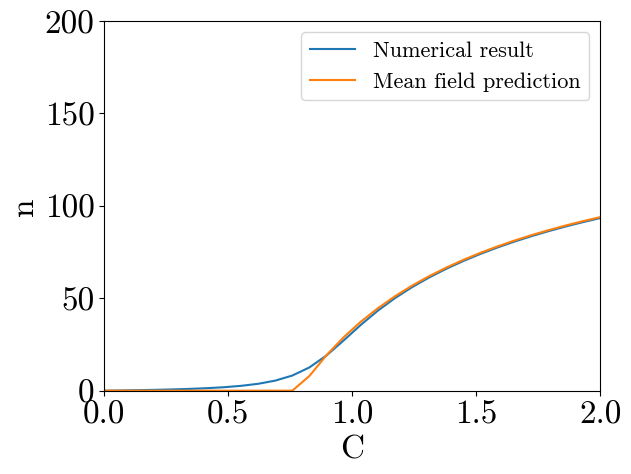

In [61]:
plt.plot(C,n,label='Numerical result')
plt.plot(C,mfs,label='Mean field prediction')
plt.xlim([np.min(C),np.max(C)])
plt.ylim([0,200])
plt.xlabel('C')
plt.ylabel('n')
plt.legend()
plt.show()

In [62]:
quad_ang = np.pi-(theta)/2 # Quadrature angle that specifies the field's quadrature to measure
X_ang = a*np.exp(-1j*quad_ang)+a.dag()*np.exp(1j*quad_ang) # Chosen quadrature operator

In [63]:
fluc = np.zeros(np.size(C),dtype='complex')

for i in range(np.size(C)):
    fluc[i] = expect(X_ang**2,rho_ss[i])-expect(X_ang,rho_ss[i])**2 # Calculate quadrature fluctuations

c:\Users\rodri\anaconda3\envs\myenv\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\rodri\anaconda3\envs\myenv\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


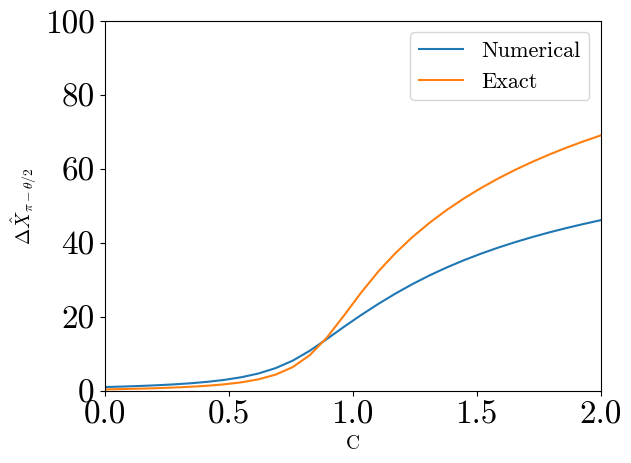

In [64]:
plt.plot(C,fluc,label='Numerical')
plt.plot(C,(2*n+1)*np.exp(-2*r),label='Exact')
plt.xlim([np.min(C),np.max(C)])
plt.ylim([0,100])
plt.xlabel('C',fontsize=14)
plt.ylabel(r'$\Delta\hat{X}_{\pi-\theta/2}$',fontsize=14)
plt.legend()
plt.show()

### 2. Wigner distribution

In [283]:
index = 21 # Select the value of the cooperativity by writting its index

In [284]:
C[index]

1.4482758620689657

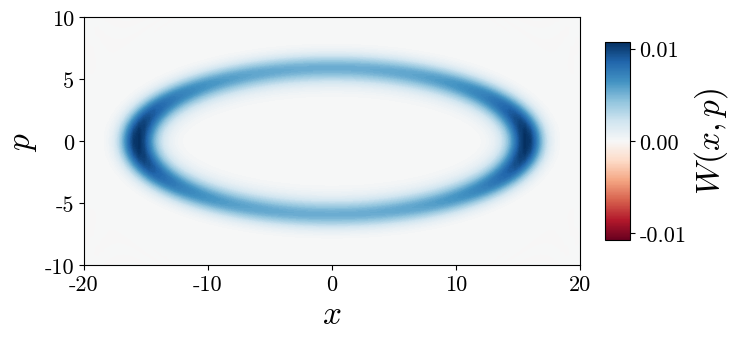

In [285]:
wr = wigner_rep(rhos = rho_ss[index]) # Initialize the calculation with its parameters
x_lim = 20 # X-Axis limits
p_lim = 10 # P-Axis limits
wr.wigner_plot(x_lim,p_lim) # Calculate the Wigner function

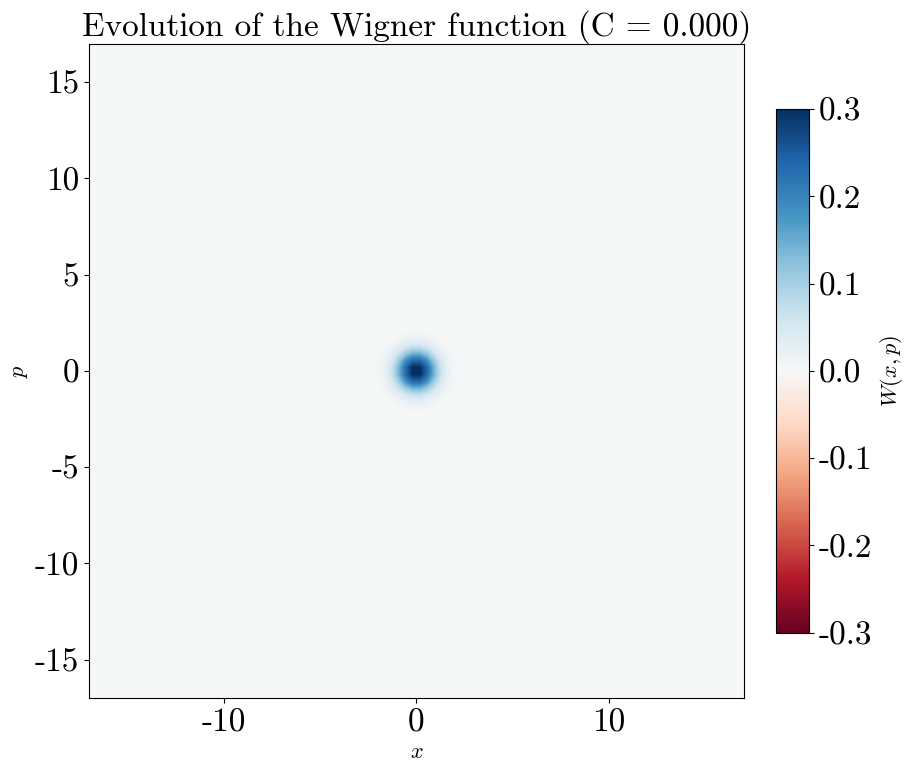

In [67]:
wigner_rep(rhos = rho_ss).wigner_animation(17,17,C,figname = 'Heff_Var_C',speed = 100, mrname = 'C') # Create an animation for the whole range of C

### 3. Emission spectrum $S(\omega)$

In [313]:
N_spec = 110 # We reduce the dimension of the Hilbert space for faster computation
a_spec = tensor(destroy(N_spec),identity(2)) # Redefinition of the annihilation operator
sigma_spec = tensor(identity(N_spec),basis(2,0)*basis(2,1).dag()) # Redefinition of the lowering operator of the two-level system

In [165]:
spec = np.zeros([2000,np.size(C)])
wlist = np.zeros([2000,np.size(C)])
for i in tqdm(range(np.size(C))):
        wlist[:,i], spec[:,i] = spec_prop(a_spec,H_def(a_spec,sigma_spec,0,0,g,r,theta),Lops_def(a_spec,sigma_spec,k[i],P[i],eta)).emis_spec(k[i],tau_f=80)

100%|██████████| 30/30 [38:51<00:00, 77.71s/it]


In [204]:
spec2 = np.zeros([2000,np.size(C)-1])
wlist2 = np.zeros([2000,np.size(C)-1])
for i in tqdm(range(np.size(C)-1)):
        wlist2[:,i] = wlist[:,i+1]/k[i+1]
        spec2[:,i] = spec[:,i+1]/np.max(spec[:,i+1])

100%|██████████| 29/29 [00:00<00:00, 14537.45it/s]


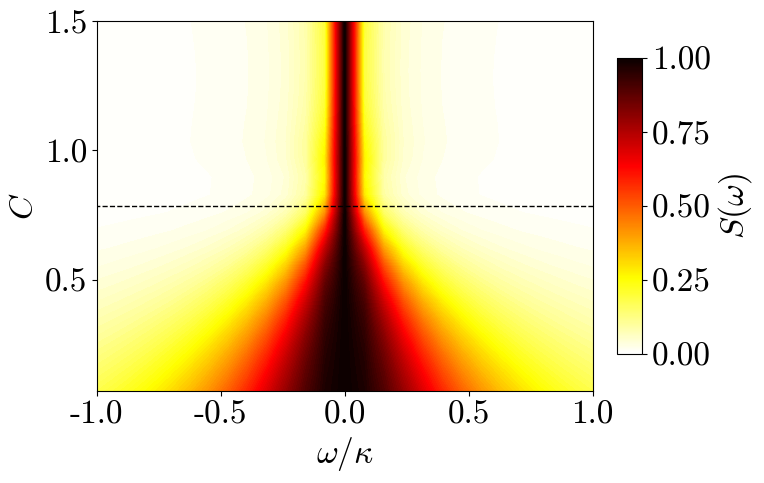

In [256]:
nrm = mpl.colors.Normalize(0,np.max(spec2[:,28])) # Colorbar settings

fig, ax = plt.subplots()

cbar = plt.colorbar(cm.ScalarMappable(norm=nrm, cmap=cm.hot_r), label=r'$S(\omega)$', cax = ax.inset_axes([1.05, 0.1, 0.05, 0.8]))
ax.contourf(wlist2[:,0], C[1:], np.transpose(spec2), 100, cmap=cm.hot_r, norm=nrm)
ax.plot([-3,3],[np.cosh(r)**-2,np.cosh(r)**-2],'--',lw=1,color='k')
ax.set_ylabel(r'$C$')
ax.set_xlabel(r'$\omega/\kappa$')
ax.set_xlim([-1,1])
ax.set_ylim([0.07,1.5])

plt.show()

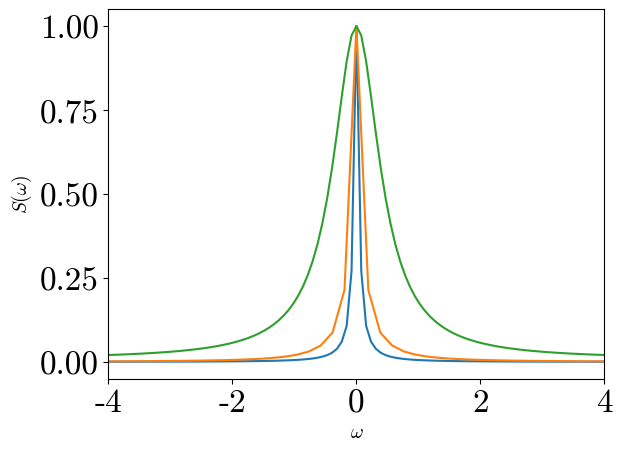

In [208]:
plt.plot(wlist[:,29]/k[29],np.real(spec[:,29])/np.max(np.real(spec[:,29])))
plt.plot(wlist[:,4]/k[24],np.real(spec[:,24])/np.max(np.real(spec[:,24])))
plt.plot(wlist[:,1]/k[1],np.real(spec[:,1])/np.max(np.real(spec[:,1])))
# plt.title('freq. spectrum',fontsize=14)
plt.xlabel('$\omega$',fontsize=14)
plt.ylabel('$S(\omega)$',fontsize=14)
plt.xlim([-4,4])
plt.show()

In [259]:
esp = np.column_stack([wlist2[:,0], spec2])
np.savetxt('.\SEC_IV_A/SPEC'+str(format(r,'.2f'))+'_'+str(format(n_q,'.0f'))+'.txt',esp)

### 4. Second order coherence function $g^{(2)}(\tau)$

In [301]:
sys.modules.pop('src_2_0')

<module 'src_2_0' from 'c:\\users\\rodri\\onedrive\\documentos\\github\\squeezed-lasing\\squeezed_lasing\\src_2_0.py'>

In [302]:
from src_2_0 import *

In [314]:
tau_vec = np.zeros([10001,np.size(C)-2])
g_2 = np.zeros([10001,np.size(C)-2])
for i in tqdm(range(np.size(C)-2)):
        rho_spec = steadystate(H_def(a_spec,sigma_spec,0,0,g,r,theta),Lops_def(a_spec,sigma_spec,k[i+1],P[i+1],eta)) # Calculate the steady state
        tau_vec[:,i], g_2[:,i] = spec_prop(a_spec,H_def(a_spec,sigma_spec,0,0,g,r,theta),Lops_def(a_spec,sigma_spec,k[i+1],P[i+1],eta)).corr_2(rho_spec,k[i+1],tau_f=25) # Calculation of the second order coherence function

  0%|          | 0/28 [00:00<?, ?it/s]C:\Users\rodri\AppData\Local\Temp\ipykernel_32032\1905339547.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  tau_vec[:,i], g_2[:,i] = spec_prop(a_spec,H_def(a_spec,sigma_spec,0,0,g,r,theta),Lops_def(a_spec,sigma_spec,k[i+1],P[i+1],eta)).corr_2(rho_spec,k[i+1],tau_f=25) # Calculation of the second order coherence function
100%|██████████| 28/28 [1:28:29<00:00, 189.63s/it]


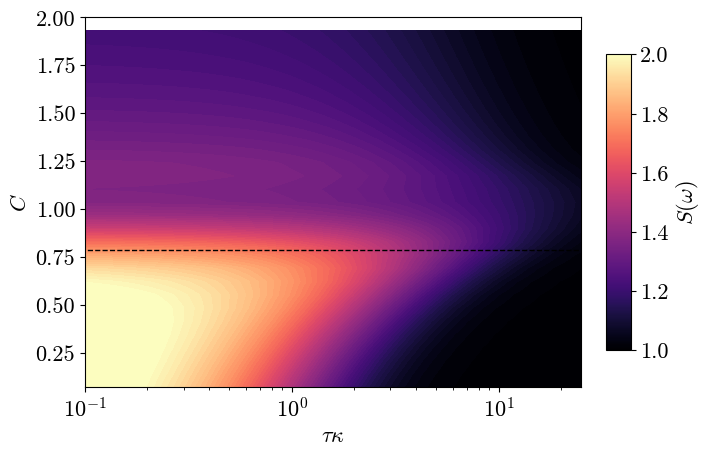

In [320]:
nrm2 = mpl.colors.Normalize(1,2) # Colorbar settings

fig2, ax2 = plt.subplots()

cbar2 = plt.colorbar(cm.ScalarMappable(norm=nrm2, cmap=cm.magma), label=r'$S(\omega)$', cax = ax2.inset_axes([1.05, 0.1, 0.05, 0.8]))
ax2.contourf(tau_vec[:,0]*k[1], C[1:29], np.transpose(g_2), 100, cmap=cm.magma, norm=nrm2)
ax2.plot([0,300],[np.cosh(r)**-2,np.cosh(r)**-2],'--',lw=1,color='k')
ax2.set_ylabel(r'$C$')
ax2.set_xlabel(r'$\tau\kappa$')
ax2.set_xscale('log')
ax2.set_xlim([0.1,max(tau_vec[:,0]*k[1])])
ax2.set_ylim([0.07,2])

plt.show()

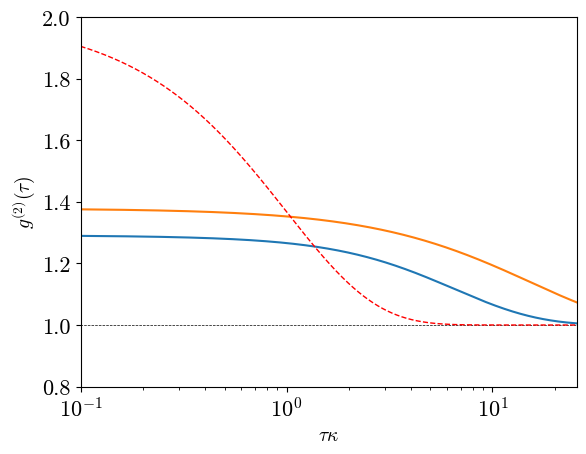

In [318]:
i = 21
j = 14
plt.plot(tau_vec[:,i]*k[i],np.real(g_2[:,i]))
plt.plot(tau_vec[:,j]*k[j],np.real(g_2[:,j]))
plt.plot([0,max(tau_vec[:,i])],[1,1],'--',lw=0.5,color='k')
plt.plot(tau_vec[:,i]*k[i],np.ones(np.size(tau_vec[:,i]))+np.exp(-tau_vec[:,i]*k[i]),'--',lw=1,color='r',label='thermal')
plt.ylim([0.8,2])
plt.xlim([0.1,max(tau_vec[:,i]*k[i])])
plt.xlabel(r'$\tau\kappa$',fontsize=14)
plt.ylabel(r'$g^{(2)}(\tau)$',fontsize=14)
plt.semilogx()
# plt.title('Second order coherence function',fontsize=14)
plt.show()

In [321]:
esp = np.column_stack([tau_vec[:,0]*k[1],g_2])
np.savetxt('.\SEC_IV_A/g2'+str(format(r,'.2f'))+'_'+str(format(n_q,'.0f'))+'.txt',esp)